In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import Counter
import glob
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
def set_seaborn_style():
    # Idk why we have to call this twice for it to work but... here we are
    sns.set(rc={'figure.figsize':(8,5)})
    sns.set_theme(style="whitegrid")
set_seaborn_style()
import nltk
from gensim.models import Word2Vec
import joblib
from tqdm import tqdm
tqdm.pandas()

import hptutil

In [3]:
global_window_high = 21
global_window_low = 9
global_epochs = 80
global_min_count = 10
global_seed = 1949
fig_path = os.path.join("..","figs")

In [4]:
token_sets = [
    ["black","colored","n*****","nigger","niggers","negro","negros","negroes","blacks"],
    ["child","children","childs","chillun"],
    ["coop","coops"],
    ["field","fields"],
    #["free"]
    ["house","houses"],
    ["man","men","mans"],
    ["master","marster","masters","marsters","marse",'massa'],
    #["quarters","quarter","coop","coops"],
    ["slave","slaves"],
    ["white","whites"],
    ["woman","women"],
    ["exslave","exslaves"],
    ["slavery","slavry"],
    ['darky', 'darkey'],
    ['thing','ting'],
    ['have', 'hab'],
    ['live', 'lib'],
    ['was', 'wus'],
    ['folk', 'folks'],
]
token_map = {}
for cur_token_set in token_sets:
    first_token = cur_token_set[0]
    for cur_other_token in cur_token_set[1:]:
        token_map[cur_other_token] = first_token
token_map

{'colored': 'black',
 'n*****': 'black',
 'nigger': 'black',
 'niggers': 'black',
 'negro': 'black',
 'negros': 'black',
 'negroes': 'black',
 'blacks': 'black',
 'children': 'child',
 'childs': 'child',
 'chillun': 'child',
 'coops': 'coop',
 'fields': 'field',
 'houses': 'house',
 'men': 'man',
 'mans': 'man',
 'marster': 'master',
 'masters': 'master',
 'marsters': 'master',
 'marse': 'master',
 'massa': 'master',
 'slaves': 'slave',
 'whites': 'white',
 'women': 'woman',
 'exslaves': 'exslave',
 'slavry': 'slavery',
 'darkey': 'darky',
 'ting': 'thing',
 'hab': 'have',
 'lib': 'live',
 'wus': 'was',
 'folks': 'folk'}

In [5]:
stopwords_en = nltk.corpus.stopwords.words('english')
stopwords_custom = [
    # Alphabetical
    'abc', 'ah', 'ai', 'around', 'atter', 'aw', 'can', 'come', 'dar', 'dat', 'day', 'de', "dey", 'em', 'er',
    'every', 'fa', 'far',
    'go', 'got', 'jes', 'know', 'move',
    'n', 'none', 'nt',
    'oh', 'old', 'ole', 'p', 'say', 'see', 'still', 'tell', 'th', 'time', 'try',
    'us', 'uv', 'uz', 'w', "war", 'would', 'wuz', 'year', 'yo', 'yuh',
    '$', '_',
    # Unordered
    'make', 'never', 'take', 'could', 'bout', 'live', 'en', 'wid', 'big', 'back',
    'dem', 'give', 'place', 'ter', 'bear', 'get', 'like', 'little', 'do', 'use', 'long',
    'well', 'den', 'two', 'dere', 'way', 'thing', 'much', 'put', 'ge', 'uh',
    'call', 'git', 'run', 'keep', 'cause', 'think', 'remember', 'wus',
    'look', 'away', 'let', 'yes', 'many', 'dis', 'till', 'ever', 'lot', 'first', 'sho',
    'nothin', 'always', 'member', 'round', 'sometimes', 'not', 'fer', 'lak',
    # months
    'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september',
    'october', 'november', 'december',
    # numbers
    'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
    'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen',
    'eighteen', 'nineteen', 'twenty',
    'thirtysix', 'fifty', 'fiftyfive', 'eighty', 'eightytwo', 'eightyseven', 'ninety',
    'once', 'twice', 'third', 'fourth', 'fifth', 'sixth', 'seventh', 'eighth', 'ninth', 'tenth',
]
stopwords_en_full = stopwords_en + stopwords_custom

In [6]:
state_paths = glob.glob("../WPA_Online_Appendix/Narratives by State/*")

In [7]:
cur_path = state_paths[0]

In [8]:
wpa_texts = []

In [9]:
def load_text(fpath):
    with open(fpath, 'r', encoding='utf-8') as infile:
        text = infile.read()
    return text

### Loading

In [10]:
for cur_path in state_paths:
    cur_state = os.path.basename(cur_path)
    for cur_subdir in ["Black","Unidentified","White"]:
        subdir_path = os.path.join(cur_path, cur_subdir)
        subdir_fpaths = glob.glob(os.path.join(subdir_path, "*"))
        for cur_subdir_fpath in subdir_fpaths:
            file_data = {}
            file_data['text_raw'] = load_text(cur_subdir_fpath)
            file_data['fname'] = os.path.basename(cur_subdir_fpath)
            file_data['race'] = cur_subdir
            file_data['state'] = cur_state
            wpa_texts.append(file_data)

In [11]:
wpa_texts[0]

{'text_raw': '"I was born in the Junction city community and belonged to the Cooks. I\nwas ten years old at surrender. Mother and father had 12 children and we\nlived in a one room log cabin and cooked on a fireplace and oven. Mos\nand Miss Cook did not allow ma and pa to whip me. When ever I do\nsomething and I knew I was going to get a whipping I would make it to\nold Miss. She would keep me from getting that whipping. I was a devilish\nboy. I would do everything in the world I could think of just for\ndevilment. Old mos was sure good to his slaves. I never went to school\na day in my life. Old Miss would carry me to church sometimes when it\nwas hot so we could fan for her. We used palmeter fan leaves for fans.\nWe ate pretty good in slavery time, but we did not have all of this late\nstuff. Some of our dishes was possum stew, vegetables, persimmon pie and\ntato bread. Ma did not allow us to sit around grown folks. When they\nwere talking she always made us get under the bed. Our be

In [12]:
wpa_df = pd.DataFrame(wpa_texts)
wpa_df

,text_raw,fname,race,state
0,"""I was born in the Junction city community and...",Anderson 1.txt,Black,AR
1,"""I was born in Alabama. My old mistress and ma...",Anderson 10.txt,Black,AR
2,"""O. C. Hardy is my name and I is 69 years old....",Anderson 11.txt,Black,AR
3,"""I was born in Farmerville, La., I don't know ...",Anderson 12.txt,Black,AR
4,"""I was born in Union Parish, Louisiana in the ...",Anderson 13.txt,Black,AR
...,...,...,...,...
1669,One of the rooms in the Old Folks Home for Col...,Dunston 2.txt,Black,VA
1670,"Mrs. Georgina Giwbs, an ex-slave, resides at 7...",Dunston.txt,Black,VA
1671,"Mrs. Marriah Hines--Born July 4, 1835, South H...",Hoggard 1.txt,Black,VA
1672,History of Ex-slave and Civil War Veteran\n\nC...,Hoggard.txt,Black,VA


### Cleaning

In [13]:
from nltk import WordNetLemmatizer
from multiprocessing import Pool

wnl = WordNetLemmatizer()

def lemmed(text, cores=4): # tweak cores as needed
    with Pool(processes=cores) as pool:
        wnl = WordNetLemmatizer()
        result = pool.map(wnl.lemmatize, text)
    return result

In [14]:
punct_chars = ".,\"':!?;()“”’`&[]1234567890–§-—"
def remove_punct(token):
    return "".join([t for t in token if t not in punct_chars])
def clean_text(text):
    all_sent_tokens = []
    text_sents = nltk.sent_tokenize(text, "english")
    for cur_sent in text_sents:
        sent_tokens = nltk.word_tokenize(cur_sent, "english")
        clean_tokens = [t.lower() for t in sent_tokens]
        clean_tokens = [remove_punct(t) for t in clean_tokens]
        clean_tokens = [t for t in clean_tokens if t not in stopwords_en_full]
        clean_tokens = [t for t in clean_tokens if len(t) > 0]
        clean_tokens = [(token_map[t] if t in token_map else t) for t in clean_tokens]
        # Lastly, lemmatize using spacy
        #clean_sent = " ".join(clean_tokens)
        #clean_doc = spacy_en(clean_sent)
        #clean_lemmas = [cur_token.lemma_ for cur_token in clean_doc]
        clean_lemmas = [wnl.lemmatize(t) for t in clean_tokens]
        all_sent_tokens.append(clean_lemmas)
    return all_sent_tokens

In [15]:
wpa_df['text'] = wpa_df['text_raw'].progress_apply(clean_text)

100%|██████████| 1674/1674 [00:18<00:00, 91.68it/s] 


In [16]:
wpa_df.iloc[0]['text']

[['born', 'junction', 'city', 'community', 'belonged', 'cook'],
 ['year', 'surrender'],
 ['mother',
  'father',
  'child',
  'lived',
  'room',
  'log',
  'cabin',
  'cooked',
  'fireplace',
  'oven'],
 ['mo', 'miss', 'cook', 'allow', 'pa', 'whip'],
 ['something', 'knew', 'going', 'whipping', 'miss'],
 ['getting', 'whipping'],
 ['devilish', 'boy'],
 ['everything', 'world', 'devilment'],
 ['mo', 'sure', 'good', 'slave'],
 ['went', 'school', 'life'],
 ['miss', 'carry', 'church', 'hot', 'fan'],
 ['used', 'palmeter', 'fan', 'leaf', 'fan'],
 ['ate', 'pretty', 'good', 'slavery', 'late', 'stuff'],
 ['dish', 'possum', 'stew', 'vegetable', 'persimmon', 'pie', 'tato', 'bread'],
 ['allow', 'sit', 'grown', 'folk'],
 ['talking', 'made', 'bed'],
 ['bed', 'made', 'pine', 'pole'],
 ['child', 'slept', 'pallet', 'floor'],
 ['slave',
  'married',
  'slavery',
  'jumped',
  'broom',
  'separated',
  'jumped',
  'backward',
  'broom'],
 ['time', 'better', 'slavery', 'notion', 'hungry', 'neither', 'necked']

In [17]:
wpa_df.to_pickle("wpa_text_df.pkl")

### (Start from here to skip cleaning)

In [18]:
wpa_df = pd.read_pickle("wpa_text_df.pkl")

In [19]:
wpa_df

,text_raw,fname,race,state,text
0,"""I was born in the Junction city community and...",Anderson 1.txt,Black,AR,"[[born, junction, city, community, belonged, c..."
1,"""I was born in Alabama. My old mistress and ma...",Anderson 10.txt,Black,AR,"[[born, alabama], [mistress, master, told, bor..."
2,"""O. C. Hardy is my name and I is 69 years old....",Anderson 11.txt,Black,AR,"[[c, hardy, name, year], [hw, lack], [kwf, rea..."
3,"""I was born in Farmerville, La., I don't know ...",Anderson 12.txt,Black,AR,"[[born, farmerville, la], [year, surrender], [..."
4,"""I was born in Union Parish, Louisiana in the ...",Anderson 13.txt,Black,AR,"[[born, union, parish, louisiana, white, folk,..."
...,...,...,...,...,...
1669,One of the rooms in the Old Folks Home for Col...,Dunston 2.txt,Black,VA,"[[room, folk, home, black, portsmouth, virgini..."
1670,"Mrs. Georgina Giwbs, an ex-slave, resides at 7...",Dunston.txt,Black,VA,"[[mr, georgina, giwbs, exslave, resides, linds..."
1671,"Mrs. Marriah Hines--Born July 4, 1835, South H...",Hoggard 1.txt,Black,VA,"[[mr, marriah, hines, born, south, hampton, co..."
1672,History of Ex-slave and Civil War Veteran\n\nC...,Hoggard.txt,Black,VA,"[[history, exslave, civil, veteran, charles, g..."


In [20]:
# Cluster genders
gend_male = [
    'man',
    'boy',
    'father',
    'son',
    'husband',
    'grandson',
    'pa', 'papa', 'pappy',
    'brothers',
    'brother',
    'grandpa',
    'grandfather',
    'soninlaw',
    'stepfather',
    'gentleman',
    'mr', 'mister',
    'uncle',
]
gen_male_ext = [
    'roger', 'alfred', 'randall', 'billy', 'jake', 'nicholas', 'jim',
    'col', 'colonel', 'daddy',
]
gend_female = [
    'woman',
    'miss',
    'girl',
    'wife',
    'mother',
    'mammy',
    'daughter',
    'sisters',
    'sister',
    'grandma',
    'grandmother',
    'missus',
    'granddaughter',
    'mistress', 'mistess',
    'maam', 'ms', 'mrs',
    'aunt',
    'mama',
    'gal',
]
gen_female_ext = [
    'ann', 'lucy', 'nellie', 'maggie', 'elizabeth', 'mary', 'mamie', 'marse',
]
map_gend = {token: 'man' for token in gend_male}
map_gend.update({token: 'woman' for token in gend_female})

In [21]:
def get_mapped_token(word, replacement_map):
    return replacement_map[word] if word in replacement_map else word

def replace_word_tokens(word_tokens, replacement_map):
    return [get_mapped_token(w, replacement_map) for w in word_tokens]

def remove_word_tokens(word_tokens, remove_list):
    return [w for w in word_tokens if w not in remove_list]

def replace_sent_tokens(orig_sent_tokens, replacement_map):
    new_sent_tokens = [replace_word_tokens(sent, replacement_map) for sent in orig_sent_tokens]
    return new_sent_tokens

def remove_sent_tokens(orig_sent_tokens, remove_list):
    new_sent_tokens = [remove_word_tokens(sent, remove_list) for sent in orig_sent_tokens]
    # Remove empty sents
    new_sent_tokens = [t for t in new_sent_tokens if len(t) > 0]
    return new_sent_tokens


## Here we make a version where the gendered words are pre-clustered

In [22]:
corpus_sent_tokens = []
corpus_sent_tokens_gend = []
for row_index, row in wpa_df.iterrows():
    cur_sent_tokens = row['text']
    #print(cur_sent_tokens[:5])
    # Gender map
    cur_sent_tokens_gend = replace_sent_tokens(cur_sent_tokens, map_gend)
    #print(cur_sent_tokens[:5])
    #break
    corpus_sent_tokens.extend(cur_sent_tokens)
    corpus_sent_tokens_gend.extend(cur_sent_tokens_gend)

In [23]:
# For the sake of getting individual token counts, we combine into a giant list here
# (But this is just for sanity-checking)
def combine_sent_tokens(sent_tokens):
    tokens_combined = []
    for cur_sent_tokens in sent_tokens:
        tokens_combined.extend(cur_sent_tokens)
    return tokens_combined
all_tokens = combine_sent_tokens(corpus_sent_tokens)

In [24]:
def get_token_counts(tokens):
    clean_tokens_count = Counter(tokens)
    counts_sorted = sorted(clean_tokens_count.items(), key=lambda x: x[1], reverse=True)
    return counts_sorted
tcounts = get_token_counts(all_tokens)
tcounts

[('master', 8273),
 ('black', 7187),
 ('slave', 6358),
 ('white', 5642),
 ('man', 5364),
 ('house', 5156),
 ('folk', 4888),
 ('good', 4863),
 ('child', 4800),
 ('went', 4364),
 ('mother', 4252),
 ('year', 3723),
 ('said', 3697),
 ('work', 3395),
 ('mr', 3155),
 ('made', 3016),
 ('right', 2852),
 ('father', 2831),
 ('plantation', 2736),
 ('people', 2673),
 ('done', 2635),
 ('name', 2484),
 ('used', 2351),
 ('home', 2342),
 ('married', 2228),
 ('born', 2207),
 ('miss', 2179),
 ('night', 2120),
 ('told', 2111),
 ('yankee', 1999),
 ('took', 1989),
 ('died', 1971),
 ('day', 1964),
 ('church', 1936),
 ('lived', 1907),
 ('woman', 1901),
 ('boy', 1862),
 ('young', 1858),
 ('time', 1800),
 ('free', 1666),
 ('county', 1638),
 ('eat', 1583),
 ('slavery', 1497),
 ('life', 1490),
 ('field', 1484),
 ('freedom', 1469),
 ('money', 1458),
 ('sold', 1452),
 ('heard', 1429),
 ('called', 1418),
 ('came', 1413),
 ('thing', 1402),
 ('worked', 1394),
 ('family', 1376),
 ('wife', 1351),
 ('want', 1348),
 ('ma

In [25]:
# # 300-dim, window=21
# wpa_model_highwin = Word2Vec(
#     sentences=corpus_sent_tokens, vector_size=300,
#     window=global_window_high,
#     min_count=global_min_count, workers=8,
#     epochs=global_epochs, seed=global_seed
# )
# wpa_model_highwin.save("w2v_wpa_highwin.model")
# 300-dim, window=9
wpa_model_lowwin = Word2Vec(
    sentences=corpus_sent_tokens, vector_size=300,
    window=global_window_low,
    min_count=global_min_count, workers=8,
    epochs=global_epochs, seed=global_seed
)
wpa_model_lowwin_gend = Word2Vec(
    sentences=corpus_sent_tokens_gend, vector_size=300,
    window=global_window_low,
    min_count=global_min_count, workers=8,
    epochs=global_epochs, seed=global_seed
)
# 100-dim
#wpa_model = Word2Vec(sentences=corpus_sent_tokens, vector_size=100, window=global_window,
#                     min_count=4, workers=8, epochs=global_epochs)

## Export (for TensorFlow)

[https://projector.tensorflow.org/](https://projector.tensorflow.org/)

In [26]:
def export_tf(model, token_counts, tf_N):
    # Keep only the top N most-common words
    top_n_tokens = [t[0] for t in token_counts[:tf_N]]
    model_vec_df = pd.DataFrame(model.wv.vectors, index=model.wv.index_to_key)
    model_vec_df_sub = model_vec_df[model_vec_df.index.isin(top_n_tokens)].copy()
    # Export vectors
    model_vec_df_sub.to_csv("wpa_vecs_tf.tsv", sep="\t", index=False, header=False)
    # Metadata
    model_meta_df = pd.DataFrame(model_vec_df_sub.index, columns=["token"])
    model_meta_df.to_csv("wpa_meta_tf.tsv", sep="\t", header=False, index=False)
    return model_vec_df_sub, model_meta_df

In [27]:
vec_df, meta_df = export_tf(wpa_model_lowwin, tcounts, 1500)
vec_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
master,0.022543,-0.288221,0.113888,0.506025,-0.251065,0.523576,-0.976467,0.106974,-0.480104,-1.603247,...,0.221127,0.157061,0.156188,-0.214477,0.792065,0.138209,0.625182,-0.038374,1.519970,-0.440423
black,-0.464287,0.125906,-0.641358,0.952906,0.094673,0.920534,-0.897289,0.355507,-0.506286,0.394683,...,-0.132428,-0.267561,0.228856,0.003560,0.792688,-0.253491,-0.184414,-0.628600,0.662658,-0.188722
slave,0.584279,0.072831,-0.092089,0.384946,-0.464161,-0.076048,-1.017395,-0.164490,-1.603700,0.143436,...,0.101214,1.129685,0.688682,-0.111653,-0.287914,0.118754,-0.794785,-0.418130,0.612775,-0.688853
white,-0.436605,-0.978217,-1.001445,0.401196,-2.281483,0.092821,-0.402683,-0.726331,0.970221,0.430271,...,0.629940,-0.380549,-0.074244,-0.152935,0.190552,-0.042474,0.220343,-0.023477,-0.073835,-0.373601
man,0.380748,-0.933800,-0.594153,-0.004503,-0.659954,1.243544,-0.631732,-0.897822,0.370410,0.450214,...,-0.009695,0.968744,0.000354,-0.034775,0.250908,-0.381490,0.176244,-0.156845,0.221454,-0.084287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
naked,0.306421,-1.610552,-0.633283,-0.840449,-0.883989,0.621426,-1.650573,-0.335689,-0.247261,0.282069,...,-0.888657,0.595995,-1.013689,-0.323083,-0.767961,0.551644,1.599646,0.635693,0.932844,0.031321
sand,0.057732,0.154764,0.290438,0.617301,1.560652,-0.903573,2.416245,-0.678608,-0.398551,-1.245892,...,-1.843976,0.718076,1.321827,-0.932374,-0.648318,0.366570,1.605295,0.814785,-0.111689,-0.013376
attend,2.362545,-1.141649,-0.705885,0.924770,0.895021,0.968267,0.954351,0.623054,-1.068112,-0.744889,...,1.686368,0.658988,1.122719,-1.149837,-1.674314,0.551697,-0.616445,-1.506158,-0.065883,0.713435
federal,2.463107,0.689576,1.442922,-0.872957,1.125834,-0.998520,0.793645,-0.556652,1.438048,-0.898605,...,-0.415457,0.713119,1.689072,0.366770,-1.604385,0.442381,0.985128,2.755091,0.913665,1.434210


## Low-dim model (for 2d plotting)

In [28]:
wpa_model_lowwin.wv.similar_by_word("man")

[('folk', 0.5378397703170776),
 ('black', 0.4622129201889038),
 ('people', 0.4398829936981201),
 ('slave', 0.3812119960784912),
 ('woman', 0.3759816288948059),
 ('master', 0.37009119987487793),
 ('father', 0.3181830048561096),
 ('boy', 0.30139681696891785),
 ('overseer', 0.26503822207450867),
 ('fellow', 0.2519229054450989)]

In [29]:
#timeit -r1 -n1
wpa_model_lowdim = Word2Vec(
    sentences=corpus_sent_tokens, vector_size=2,
    #window=global_window,
    window=global_window_low,
    min_count=global_min_count, workers=8,
    #epochs=global_epochs,
    epochs=global_epochs,
    seed=1949,
)
wpa_model_lowdim.save("w2v_wpa_lowdim.model")
wpa_model_lowdim_gend = Word2Vec(
    sentences=corpus_sent_tokens_gend, vector_size=2,
    #window=global_window,
    window=global_window_low,
    min_count=global_min_count, workers=8,
    #epochs=global_epochs,
    epochs=global_epochs,
    seed=1949,
)
wpa_model_lowdim_gend.save("w2v_wpa_lowdim_gend.model")

In [30]:
#len(wpa_model.wv)

In [31]:
len(wpa_model_lowdim_gend.wv)

5822

In [32]:
#wpa_model_lowdim.wv.similar_by_vector(np.array([1.6,-2]),topn=100)

In [33]:
#wpa_model.wv.similar_by_word("man", topn=100)
wpa_model_lowdim_gend.wv.similar_by_word("man", topn=50)

[('limit', 1.0),
 ('minnie', 1.0),
 ('meridian', 0.9999999403953552),
 ('aiken', 0.9999998807907104),
 ('wayne', 0.9999998807907104),
 ('ray', 0.9999998807907104),
 ('pike', 0.9999997019767761),
 ('hagar', 0.9999997019767761),
 ('buying', 0.9999995827674866),
 ('marion', 0.9999995827674866),
 ('peace', 0.9999995827674866),
 ('clarksville', 0.999999463558197),
 ('interested', 0.9999989867210388),
 ('tate', 0.999998927116394),
 ('acquired', 0.9999988079071045),
 ('eightysix', 0.9999983906745911),
 ('demanded', 0.9999980926513672),
 ('epps', 0.9999979734420776),
 ('farmer', 0.9999979138374329),
 ('callie', 0.9999977946281433),
 ('signed', 0.999997615814209),
 ('advantage', 0.9999973773956299),
 ('waccamaw', 0.9999969601631165),
 ('mason', 0.9999969005584717),
 ('legal', 0.9999968409538269),
 ('england', 0.9999968409538269),
 ('prominent', 0.9999967813491821),
 ('gaillard', 0.9999966621398926),
 ('employment', 0.9999966025352478),
 ('dialect', 0.9999966025352478),
 ('knowledge', 0.99999648

In [34]:
#wpa_model.wv.similar_by_word("woman", topn=100)
wpa_model_lowdim_gend.wv.similar_by_word("woman", topn=50)

[('lamar', 1.0),
 ('dinah', 1.0),
 ('unable', 0.999999463558197),
 ('liberty', 0.9999991655349731),
 ('ruled', 0.9999988675117493),
 ('flagg', 0.999998152256012),
 ('poll', 0.9999958276748657),
 ('ridley', 0.9999947547912598),
 ('keeper', 0.9999946355819702),
 ('obedient', 0.9999943375587463),
 ('aboard', 0.9999932646751404),
 ('realize', 0.9999925494194031),
 ('claimed', 0.9999924898147583),
 ('molly', 0.9999923706054688),
 ('wright', 0.9999921321868896),
 ('list', 0.9999915957450867),
 ('belle', 0.99998939037323),
 ('eason', 0.9999889731407166),
 ('frankie', 0.9999884963035583),
 ('maggie', 0.9999884366989136),
 ('committed', 0.9999874234199524),
 ('encouraged', 0.9999873638153076),
 ('recent', 0.9999872446060181),
 ('verse', 0.999987006187439),
 ('denied', 0.9999862909317017),
 ('obtain', 0.9999831318855286),
 ('ma', 0.9999829530715942),
 ('libed', 0.9999828338623047),
 ('nursed', 0.9999820590019226),
 ('nursing', 0.9999817609786987),
 ('blooded', 0.9999812245368958),
 ('mcdaniel', 

### (Run from here for updated keywords)

In [35]:
# (From the diss)
kw_main_orig = ["white","slave","master","black","man","woman",]
           #"coop","house",
           #"field",
           #"town",
           #"yard",
            #"land",
#            "prison"]
# (New)
kw_tsne = [
    "white","black","slave","master","man","woman",
    #"rich","poor",
    "slavery","freedom"
]
kw_main = kw_main_orig + [
    #"plantation",
    #"jail",
    #"free",
    #"mother", "father", "child",
    #"field",
    #"church",
    #"whip"
    #"rich",
    #"poor",
]
kw_full = kw_main + [
    "cotton",
    #"colored",
    #"n*****",
    "slavery",
    "freedom",
    "whip",
    "sold",
    "good",
    "plantation",
    "overseer",
    "beat",
    "north","south",
    "care",
    "house","field",
    "child",
    "cook","clean",
    "money"
]


In [36]:
def get_embedding_df(w2v_model, kw_list, tagged=False):
    w2v_rows = []
    emb_keywords = kw_list
    if tagged:
        emb_keywords = [kw+"[m]" for kw in kw_list] + [kw+"[h]" for kw in kw_list]
    for cur_kw in emb_keywords:
        if cur_kw not in w2v_model.wv:
            continue
        cur_vec = w2v_model.wv[cur_kw]
        cur_row = [cur_kw] + list(cur_vec)
        w2v_rows.append(cur_row)
    w2v_df = pd.DataFrame(w2v_rows, columns=['token','x','y'])
    return w2v_df

In [37]:
# For the main keywords
df = get_embedding_df(wpa_model_lowdim_gend, kw_main)
# For kw_full
#wpa_emb_df = get_embedding_df(wpa_model_lowdim, kw_full)

In [38]:
df

,token,x,y
0,white,0.978058,-0.503934
1,slave,-0.455911,-0.793117
2,master,-1.175227,-0.916850
3,black,0.752255,-0.506419
4,man,-2.147866,-1.134159
5,woman,-1.306821,-0.921412


In [39]:
# Since "slave" and "master" are so close they overlap
adjust_points = True
if adjust_points:
    wpa_adjust = {
        #"slave": (0,0.05),
        "master": (0.0,0.03),
        #"black": (0,0),
        #"white": (0,0),
    }
    df.set_index("token",inplace=True)
    for adj_token, adj_shift in wpa_adjust.items():
        df.loc[adj_token,"x"] = df.loc[adj_token,"x"] + adj_shift[0]
        df.loc[adj_token,"y"] = df.loc[adj_token,"y"] + adj_shift[1]
    df.reset_index(inplace=True)

In [40]:
pad = 0.5
xlim = (df['x'].min() - pad, df['x'].max() + pad)
width = xlim[1] - xlim[0]
ylim = (df['y'].min() - pad, df['y'].max() + pad)
height = ylim[1] - ylim[0]
label_adj = {
    #"white": (-0.075*width,0),
    "black": (-0.075*width,0),
    "woman": (-0.09*width,0),
    "man": (-0.065*width,0),
    "slave": (-0.075*width,0),
}

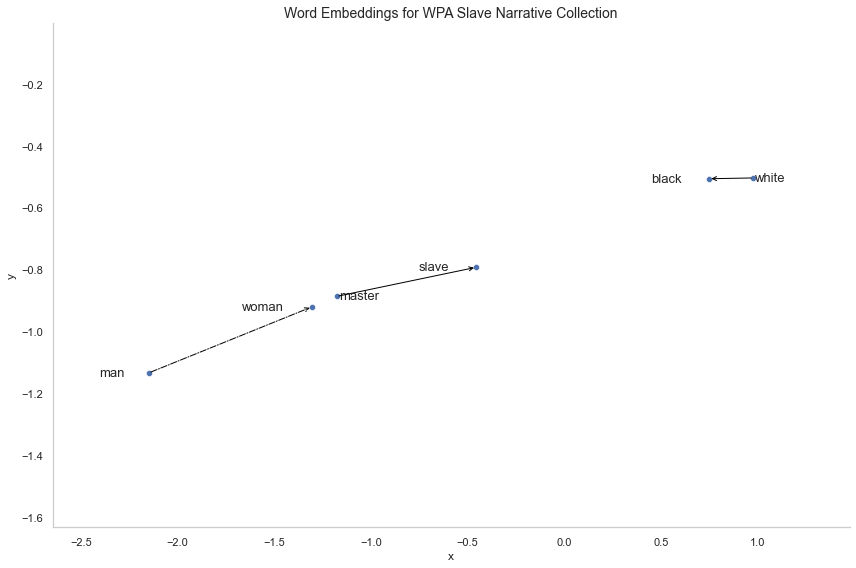

In [41]:
set_seaborn_style()
plt.figure(figsize=(12,8))
word_plot = sns.scatterplot(data=df,x='x',y='y')
word_plot.grid(False)
word_plot.set_xlim(xlim)
word_plot.set_ylim(ylim)
sns.despine(bottom=False, left=False, right=True, top=True)
#word_plot.set_xticks([])
#word_plot.set_yticks([])
word_plot.set_title("Word Embeddings for WPA Slave Narrative Collection", fontdict={'size':14})
hptutil.label_points(df['x'], df['y'], df['token'], plt.gca(), x_offset=0.01, adjustments=label_adj)
# Line from white to black
hptutil.draw_arrow(df, "white", "black", astyle="->")
hptutil.draw_arrow(df, "master", "slave", astyle="->")
#draw_arrow(df, "free", "prison")
hptutil.draw_arrow(
    df, "man", "woman",
    #lstyle="--"
    #lstyle=":"
    lstyle="-."
)
#plt.arrow(0.99,1.76,1,1,width=0.01,head_width=0.1,head_length=0.1,length_includes_head=True,color='black')
#plt.annotate("", xy=(0.99, 1.76), xytext=(1.96, -0.45), arrowprops=dict(arrowstyle="->",color='black'))
plt.tight_layout()
svg_fpath = os.path.join(fig_path, "wpa_embeddings.svg")
plt.savefig(svg_fpath)

Export to latex

In [42]:
df.set_index('token', inplace=True)

In [43]:
# For exporting
import hptutil
import pyperclip
tex_str = hptutil.custom_latex_export(df, self_contained=True, debug=False)
pyperclip.copy(tex_str)
tex_output_fpath = os.path.join("wpa_embeddings.tex")
with open(tex_output_fpath, 'w', encoding='utf-8') as outfile:
    outfile.write(tex_str)

## tSNE?

In [44]:
cur_model = wpa_model_lowwin_gend

tsne_vecs = cur_model.wv.vectors
tsne_vecs_normed = cur_model.wv.get_normed_vectors()
# Change this to change whether it uses normed vectors
tsne_vec_df = pd.DataFrame(tsne_vecs_normed, index=cur_model.wv.index_to_key)
tsne_vec_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
man,0.026651,0.016837,0.100974,0.077695,-0.121002,0.115528,0.074319,0.052603,-0.101809,0.118342,...,-0.007831,-0.048071,-0.091392,-0.031662,0.012967,0.017400,-0.023531,-0.099867,-0.039554,0.082031
woman,-0.044807,0.037199,-0.021989,0.111816,-0.107161,0.086134,0.081739,-0.059442,-0.104443,0.056720,...,-0.045955,-0.090596,-0.058264,-0.004633,-0.015893,-0.007962,-0.028158,-0.100407,0.041626,-0.029303
master,0.027482,-0.009120,0.030179,-0.019444,-0.055579,0.094466,0.021778,0.001374,-0.089551,-0.024620,...,-0.028191,0.008844,-0.052253,0.001825,-0.042983,-0.005386,-0.004702,-0.085928,0.036786,0.048482
black,-0.072359,-0.032156,-0.028689,0.019961,-0.184516,0.119629,0.030289,-0.047071,0.038061,0.135106,...,-0.028736,-0.047805,0.018488,-0.009934,-0.000386,0.034844,0.024191,0.002779,0.011058,0.043880
slave,-0.134339,0.002878,0.010141,-0.006823,-0.089158,0.001529,0.035913,-0.062195,0.034344,0.131427,...,-0.108546,-0.053111,-0.029770,0.028734,-0.060424,-0.007066,0.014866,-0.031862,-0.037500,0.034421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
firmly,0.042609,0.013004,-0.024562,0.066215,-0.082603,-0.091862,-0.078005,0.104179,0.120197,0.104596,...,0.018867,0.000326,0.023826,-0.018018,-0.020626,-0.077297,-0.005758,-0.051399,-0.012698,0.099845
crawling,0.025117,-0.078393,0.084888,0.012052,0.022910,0.051394,-0.004902,-0.041967,-0.071909,0.032822,...,0.025159,-0.000648,0.079819,-0.064287,-0.079902,-0.039981,-0.079333,-0.037998,0.028190,-0.056121
savin,-0.009597,-0.067028,-0.036183,-0.051143,-0.042927,0.001705,0.053152,-0.092026,0.041165,0.036374,...,-0.005745,0.004480,0.082285,0.099190,-0.083727,0.019266,0.000878,0.048500,0.057538,0.035737
sic,0.052029,0.039605,0.080066,-0.070040,0.028422,-0.021939,-0.083642,-0.079910,0.001093,0.059508,...,0.060587,0.132005,0.130717,0.016796,-0.107373,-0.025059,0.074822,0.070192,0.025505,-0.022679


### Select only top N

In [45]:
tsne_N = 1500
top_n_tokens = [t[0] for t in tcounts[:tsne_N]]
tsne_topn_df = tsne_vec_df[tsne_vec_df.index.isin(top_n_tokens)].copy()
tsne_topn_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
man,0.026651,0.016837,0.100974,0.077695,-0.121002,0.115528,0.074319,0.052603,-0.101809,0.118342,...,-0.007831,-0.048071,-0.091392,-0.031662,0.012967,0.017400,-0.023531,-0.099867,-0.039554,0.082031
woman,-0.044807,0.037199,-0.021989,0.111816,-0.107161,0.086134,0.081739,-0.059442,-0.104443,0.056720,...,-0.045955,-0.090596,-0.058264,-0.004633,-0.015893,-0.007962,-0.028158,-0.100407,0.041626,-0.029303
master,0.027482,-0.009120,0.030179,-0.019444,-0.055579,0.094466,0.021778,0.001374,-0.089551,-0.024620,...,-0.028191,0.008844,-0.052253,0.001825,-0.042983,-0.005386,-0.004702,-0.085928,0.036786,0.048482
black,-0.072359,-0.032156,-0.028689,0.019961,-0.184516,0.119629,0.030289,-0.047071,0.038061,0.135106,...,-0.028736,-0.047805,0.018488,-0.009934,-0.000386,0.034844,0.024191,0.002779,0.011058,0.043880
slave,-0.134339,0.002878,0.010141,-0.006823,-0.089158,0.001529,0.035913,-0.062195,0.034344,0.131427,...,-0.108546,-0.053111,-0.029770,0.028734,-0.060424,-0.007066,0.014866,-0.031862,-0.037500,0.034421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
franklin,0.008566,0.014483,-0.092574,0.109314,0.083127,-0.026338,0.041273,0.011504,0.046206,0.023091,...,0.008437,-0.089468,0.072205,-0.113821,-0.074913,0.022901,0.019481,0.030518,0.003112,-0.006919
labor,-0.003280,0.092883,0.049819,0.027037,-0.045403,-0.006735,-0.043787,0.032115,-0.131414,-0.008739,...,-0.032035,-0.000661,0.040700,0.075201,-0.072265,0.022468,0.057612,-0.027840,0.060774,-0.139254
squirrel,-0.020708,-0.025894,0.002444,-0.007732,0.029863,-0.055889,-0.012156,-0.096284,-0.037423,-0.022051,...,-0.089388,0.044709,-0.016220,0.062534,0.047895,-0.099535,-0.046160,-0.019665,-0.032331,-0.073619
camped,-0.061048,-0.003644,-0.051253,0.001493,0.034865,-0.077401,0.075787,0.029277,0.039911,0.038405,...,-0.034185,-0.009598,0.071405,0.040014,-0.085645,0.065168,0.037213,0.135809,-0.041203,0.041796


In [46]:
from sklearn.manifold import TSNE

In [47]:
tsne = TSNE(n_components=2, random_state=global_seed,
            metric='cosine',
            learning_rate=10,
            perplexity=12.0, n_jobs=8,
            n_iter=2000)

In [48]:
#timeit -r1 -n1
# Project the data in 2D
#X_tsne = tsne.fit_transform(wpa_vecs)

# Convert df to just nunmeric matrix
#X_wpa_kw = wpa_kw_df.drop(columns=['token'])
X_tsne_topn = tsne.fit_transform(tsne_topn_df)

C:\Users\jpjac\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [49]:
tsne_df_full = pd.DataFrame(X_tsne_topn, columns=['x','y'], index=tsne_topn_df.index)

In [50]:
tsne_df_full

,x,y
man,49.807411,-0.213680
woman,53.393616,-3.961056
master,49.613235,-1.007129
black,44.174366,-8.286601
slave,43.263889,-6.071627
...,...,...
franklin,50.674828,25.374142
labor,10.281645,32.457920
squirrel,-63.473106,-6.590760
camped,26.484499,48.892315


## Keep just the keywords

In [51]:
# Now just the keywords
kw_remove = ['freedom', 'slavery']
kw_filtered = [kw for kw in kw_tsne if kw not in kw_remove]
#kw_add = ['plantation', 'rich', 'poor', 'child']
kw_add = ['baby', 'child', 'rich', 'poor']
kw_final = kw_filtered + kw_add
tsne_df = tsne_df_full[tsne_df_full.index.isin(kw_final)].copy()

In [52]:
# Just rescaling the poor/rich, since they're so far away in the y direction you can't
# see the angles in the plot
tsne_df.at['centroid','x'] = tsne_df['x'].mean()
tsne_df.at['centroid','y'] = tsne_df['y'].mean()
dilation_amount = 0.85
def contract_midpoint(df, token, proportion):
    for dimension in ['x','y']:
        orig_point = df.loc[token, dimension]
        centroid = df.loc['centroid', dimension]
        midpoint = proportion * centroid + (1 - proportion) * orig_point
        df.at[token, dimension] = midpoint
contract_midpoint(tsne_df, 'poor', dilation_amount)
contract_midpoint(tsne_df, 'rich', dilation_amount)
#tsne_df.at['rich','y'] = tsne_df.loc['rich', 'y'] / 3
# And now we can drop the centroid
tsne_df = tsne_df[tsne_df.index != 'centroid'].copy()

In [53]:
tsne_df.loc['white']

x    45.466774
y    -9.030346
Name: white, dtype: float32

In [54]:
# Compute averages
white_master = (tsne_df.loc['white'] + tsne_df.loc['master']) / 2
black_slave = (tsne_df.loc['black'] + tsne_df.loc['slave']) / 2
white_master, black_slave

(x    47.540005
 y    -5.018737
 dtype: float32,
 x    43.719128
 y    -7.179114
 dtype: float32)

In [55]:
def gen_point(x, y):
    return pd.Series({'x': x, 'y': y})
tsne_df.at['whitemaster'] = gen_point(white_master['x'], white_master['y'])
tsne_df.at['blackslave'] = gen_point(black_slave['x'], black_slave['y'])

In [56]:
# Now get the continuation of whitemaster->blackslave intersecting man->woman
#tsne_df.at['negativerace'] = tsne_df.loc['whitemaster'] - tsne_df['blackslave']
#tsne_df.at['negativerace'] = tsne_df.loc['whitemaster'] + 0.9*(tsne_df.loc['whitemaster'] - tsne_df.loc['blackslave'])

In [57]:
# Find where it intersects man->woman
race_vec = tsne_df.loc['blackslave'] - tsne_df.loc['whitemaster']
gender_vec = tsne_df.loc['woman'] - tsne_df.loc['man']
race_slope = race_vec['y'] / race_vec['x']
gender_slope = gender_vec['y'] / gender_vec['x']
wm_x = tsne_df.loc['whitemaster', 'x']
wm_y = tsne_df.loc['whitemaster', 'y']
m_x = tsne_df.loc['man', 'x']
m_y = tsne_df.loc['man', 'y']
intersect_numer = (race_slope * wm_x - gender_slope * m_x) + (m_y - wm_y)
intersect_denom = race_slope - gender_slope
intersect_x = intersect_numer / intersect_denom
intersect_y = gender_slope * (intersect_x - m_x) + m_y
intersect_x, intersect_y

(51.995144, -2.4997342)

In [58]:
tsne_df.at['intersect'] = gen_point(intersect_x, intersect_y)
# Angle at the intersection
cos_theta = np.dot(race_vec, gender_vec) / (np.linalg.norm(race_vec) * np.linalg.norm(gender_vec))
vec_angle = np.arccos(cos_theta)
theta_degrees = np.rad2deg(vec_angle)
theta_degrees = str(np.round(theta_degrees, 2))
theta_degrees

'104.26'

In [59]:
tsne_xmin = tsne_df['x'].min()
tsne_xmax = tsne_df['x'].max()
tsne_xrange = tsne_xmax - tsne_xmin
tsne_xpad = 0.01*tsne_xrange
tsne_xlim = (tsne_xmin - tsne_xpad, tsne_xmax + tsne_xpad)
# y
tsne_ymin = tsne_df['y'].min()
tsne_ymax = tsne_df['y'].max()
tsne_yrange = tsne_ymax - tsne_ymin
tsne_ypad = 0.01*tsne_yrange
tsne_ylim = (tsne_ymin - tsne_ypad, tsne_ymax + tsne_ypad)

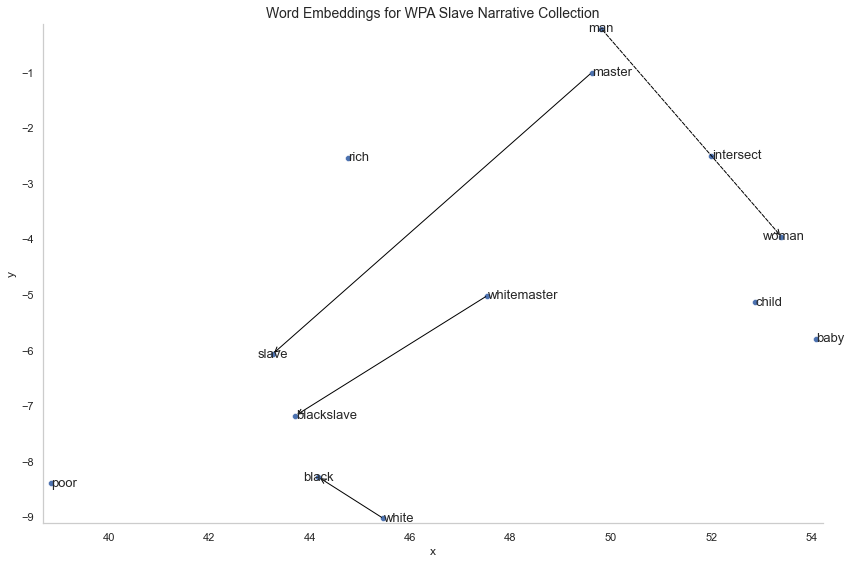

In [60]:
# Plot tSNE like it's the 2d space
set_seaborn_style()
plt.figure(figsize=(12,8))
word_plot = sns.scatterplot(data=tsne_df,x='x',y='y')
word_plot.grid(False)
word_plot.set_xlim(tsne_xlim)
word_plot.set_ylim(tsne_ylim)
sns.despine(bottom=False, left=False, right=True, top=True)
#word_plot.set_xticks([])
#word_plot.set_yticks([])
# Line from white to black
hptutil.draw_arrow(tsne_df, "white", "black")
hptutil.draw_arrow(tsne_df, "master", "slave")
hptutil.draw_arrow(tsne_df, "whitemaster", "blackslave")
hptutil.draw_arrow(tsne_df, "man", "woman", lstyle="--")
#plt.arrow(0.99,1.76,1,1,width=0.01,head_width=0.1,head_length=0.1,length_includes_head=True,color='black')
#plt.annotate("", xy=(0.99, 1.76), xytext=(1.96, -0.45), arrowprops=dict(arrowstyle="->",color='black'))
word_plot.set_title("Word Embeddings for WPA Slave Narrative Collection", fontdict={'size':14})
hptutil.label_points(tsne_df['x'], tsne_df['y'], tsne_df.index, plt.gca(), x_offset=0.01, adjustments=label_adj)
plt.tight_layout()

In [61]:
tsne_df.loc['poor','y']

-8.394489

In [62]:
# Trying this...
#logx_df = tsne_df.copy()
#logx_df['x'] = logx_df['x'].apply(np.log)
##logx_df['y'] = log_df['y'].apply(np.log)
#logx_df

In [63]:
# To latex
arrow_data = [
    {'pointA': 'man', 'pointB': 'woman', 'linestyle': '', 'arrowtype': '->'},
    #{'pointA': 'master', 'pointB': 'slave', 'linestyle': 'dashed', 'arrowtype': '->'},
    #{'pointA': 'white', 'pointB': 'black', 'linestyle': 'dashed', 'arrowtype': '->'},
    {'pointA': 'whitemaster', 'pointB': 'blackslave', 'linestyle': '', 'arrowtype': '->'},
    {'pointA': 'whitemaster', 'pointB': 'intersect', 'linestyle': 'dashed', 'arrowtype': '-'},
]
label_data = {
    'slave': {'anchor': 'south', 'xshift': 0.0, 'yshift': 0.0},
    'black': {'anchor': 'south'},
    'master': {'anchor': 'north', 'xshift': 12.0, 'yshift': 0.0},
    'woman': {'anchor': 'south', 'xshift': 2.0, 'yshift': 0.0, 'formatted': '${\\large \\entpgf{woman}}$'},
    'man': {'yshift': -2.0, 'formatted': '${\\large \\entpgf{man}}$'},
    'child': {'anchor': 'south'},
    'whitemaster': {'formatted': '${\\large \\entpgf{white} \\bowtie \\entpgf{master}}$',
                    'xshift': 8.0, 'yshift': 4.0, 'anchor': 'south'},
    'blackslave': {'formatted': '${\\large \\entpgf{black} \\bowtie \\entpgf{slave}}$', 'yshift': 0.0, 'anchor': 'south'},
    'intersect': {'draw_point': False, 'formatted': f'\\large $\\theta \\approx {theta_degrees}^\circ$',
                  'anchor': 'north', 'xshift': -29.0},
}
# Self-contained version
tsne_tex_standalone = hptutil.custom_latex_export(tsne_df, label_data=label_data, arrow_data=arrow_data,
                                       self_contained=True, pad_pct=0.1)
tex_standalone_fpath = "./tsne_standalone.tex"
with open(tex_standalone_fpath, 'w', encoding='utf-8') as outfile:
    outfile.write(tsne_tex_standalone)
# Version for paper
tsne_tex = hptutil.custom_latex_export(tsne_df, label_data=label_data, arrow_data=arrow_data,
                                                  self_contained=False, pad_pct=0.1)
tex_output_fpath = os.path.join(fig_path, "wpa_tsne_morewords.tex")
with open(tex_output_fpath, 'w', encoding='utf-8') as outfile:
    outfile.write(tsne_tex)

[Arrow()] self.dash_str = 
[Arrow()] self.dash_str = 
[Arrow()] self.dash_str = dashed,
[Arrow()] self.dash_str = 
[Arrow()] self.dash_str = 
[Arrow()] self.dash_str = dashed,


In [64]:
# Save to file
tsne_df.to_csv("./wpa_vecs_tsne.csv")
tsne_df_full.to_csv("./wpa_vecs_tsne_full.csv")

## Now with projection!

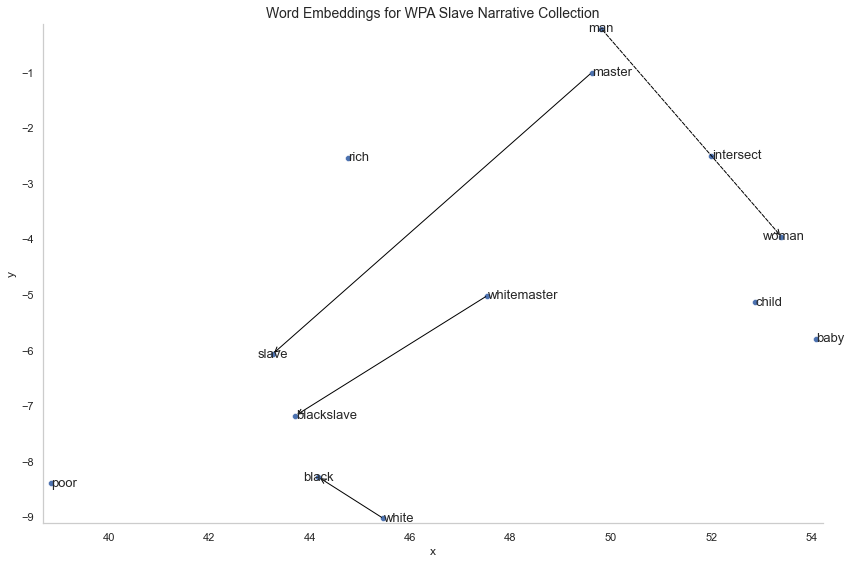

In [65]:
# Plot tSNE like it's the 2d space
set_seaborn_style()
plt.figure(figsize=(12,8))
word_plot = sns.scatterplot(data=tsne_df,x='x',y='y')
word_plot.grid(False)
word_plot.set_xlim(tsne_xlim)
word_plot.set_ylim(tsne_ylim)
sns.despine(bottom=False, left=False, right=True, top=True)
#word_plot.set_xticks([])
#word_plot.set_yticks([])
# Line from white to black
hptutil.draw_arrow(tsne_df, "white", "black")
hptutil.draw_arrow(tsne_df, "master", "slave")
hptutil.draw_arrow(tsne_df, "whitemaster", "blackslave")
hptutil.draw_arrow(tsne_df, "man", "woman", lstyle="--")
#plt.arrow(0.99,1.76,1,1,width=0.01,head_width=0.1,head_length=0.1,length_includes_head=True,color='black')
#plt.annotate("", xy=(0.99, 1.76), xytext=(1.96, -0.45), arrowprops=dict(arrowstyle="->",color='black'))
word_plot.set_title("Word Embeddings for WPA Slave Narrative Collection", fontdict={'size':14})
hptutil.label_points(tsne_df['x'], tsne_df['y'], tsne_df.index, plt.gca(), x_offset=0.01, adjustments=label_adj)
plt.tight_layout()

In [66]:
gender_vec_np = np.array(gender_vec)
#np.dot(tsne_df.loc['child'], gender_vec)

In [67]:
def normalize_vector(orig_vec):
    return orig_vec / np.sqrt(np.sum(orig_vec ** 2))

In [68]:
gender_vec_norm = normalize_vector(gender_vec_np)
race_vec_norm = normalize_vector(race_vec)

## Gender coords

In [69]:
tsne_df['vec'] = tsne_df.apply(lambda row: np.array([row['x'],row['y']]), axis=1)
tsne_df

,x,y,vec
man,49.807411,-0.213680,"[49.80741, -0.21368003]"
woman,53.393616,-3.961056,"[53.393616, -3.9610562]"
master,49.613235,-1.007129,"[49.613235, -1.0071291]"
black,44.174366,-8.286601,"[44.174366, -8.286601]"
slave,43.263889,-6.071627,"[43.26389, -6.071627]"
white,45.466774,-9.030346,"[45.466774, -9.030346]"
child,52.866508,-5.140674,"[52.86651, -5.1406736]"
baby,54.070774,-5.793362,"[54.070774, -5.7933617]"
poor,38.852177,-8.394489,"[38.852177, -8.394489]"
rich,44.761120,-2.535480,"[44.76112, -2.5354805]"


In [70]:
def get_coord(raw_vec, normed_unit_vec):
    normalized_vec = normalize_vector(raw_vec)
    return normed_unit_vec * np.dot(normalized_vec, normed_unit_vec)

def ortho_projection(orig_vec, unit_vec):
    return np.dot(orig_vec, unit_vec) / np.dot(unit_vec, unit_vec)

#tsne_df['gender_coord'] = tsne_df['vec'].apply(lambda x: get_coord(x, gender_vec_norm))
#tsne_df['race_coord'] = tsne_df['vec'].apply(lambda x: get_coord(x, race_vec_norm))
tsne_df['ortho_proj_gender'] = tsne_df['vec'].apply(lambda x: ortho_projection(x, gender_vec))
tsne_df['ortho_proj_race'] = tsne_df['vec'].apply(lambda x: ortho_projection(x, race_vec))

In [71]:
tsne_df

,x,y,vec,ortho_proj_gender,ortho_proj_race
man,49.807411,-0.213680,"[49.80741, -0.21368003]",6.668985,-9.853790
woman,53.393616,-3.961056,"[53.393616, -3.9610562]",7.668985,-10.144799
master,49.613235,-1.007129,"[49.613235, -1.0071291]",6.753620,-9.726309
black,44.174366,-8.286601,"[44.174366, -8.286601]",7.042577,-7.831416
slave,43.263889,-6.071627,"[43.26389, -6.071627]",6.612692,-7.899220
white,45.466774,-9.030346,"[45.466774, -9.030346]",7.318448,-8.004327
child,52.866508,-5.140674,"[52.86651, -5.1406736]",7.763030,-9.907991
baby,54.070774,-5.793362,"[54.070774, -5.7933617]",8.014468,-10.073633
poor,38.852177,-8.394489,"[38.852177, -8.394489]",6.348168,-6.763826
rich,44.761120,-2.535480,"[44.76112, -2.5354805]",6.319726,-8.592666


In [72]:
# Old: 0-1 scaling
def scale_coord(raw_coord, scale_min, scale_max):
    scale_numer = raw_coord - scale_min
    scale_denom = scale_max - scale_min
    return scale_numer / scale_denom

def scale_coords():
    gender_min = tsne_df['gender_coord'].min()
    gender_max = tsne_df['gender_coord'].max()
    race_min = tsne_df['race_coord'].min()
    race_max = tsne_df['race_coord'].max()
    tsne_df['gender_coord_scaled'] = tsne_df['gender_coord'].apply(lambda x: scale_coord(x, gender_min, gender_max))
    tsne_df['race_coord_scaled'] = tsne_df['race_coord'].apply(lambda x: scale_coord(x, race_min, race_max))

In [73]:
# New: just center at 0
tsne_df['gender_coord'] = tsne_df['ortho_proj_gender'] - tsne_df['ortho_proj_gender'].mean()
tsne_df['race_coord'] = tsne_df['ortho_proj_race'] - tsne_df['ortho_proj_race'].mean()

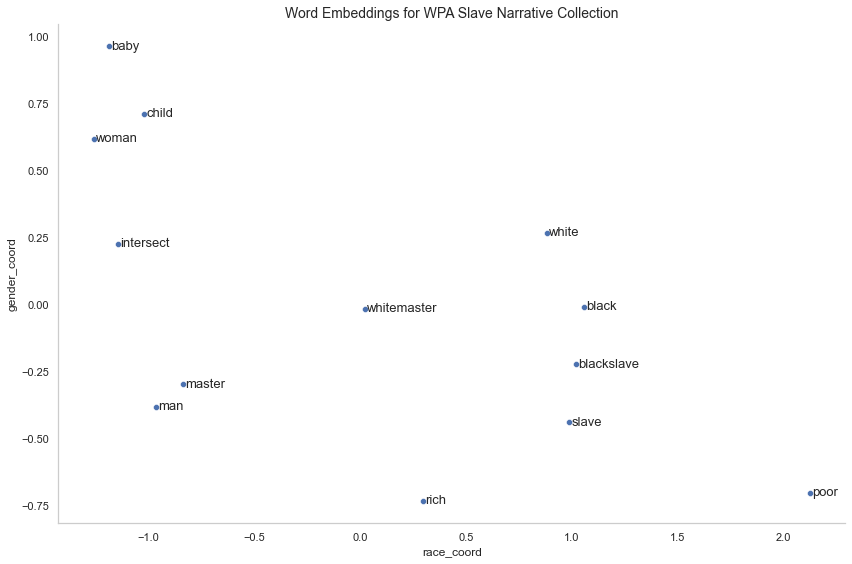

In [74]:
# Plot tSNE like it's the 2d space
#xvar = 'ortho_proj_race'
xvar = 'race_coord'
#yvar = 'ortho_proj_gender'
yvar = 'gender_coord'
set_seaborn_style()
plt.figure(figsize=(12,8))
word_plot = sns.scatterplot(data=tsne_df,x=xvar,y=yvar)
word_plot.grid(False)
#word_plot.set_xlim((-0.1,1.1))
#word_plot.set_ylim((-0.1,1.1))
sns.despine(bottom=False, left=False, right=True, top=True)
#word_plot.set_xticks([])
#word_plot.set_yticks([])
# Line from white to black
hptutil.draw_arrow(tsne_df, "white", "black")
hptutil.draw_arrow(tsne_df, "master", "slave")
hptutil.draw_arrow(tsne_df, "whitemaster", "blackslave")
hptutil.draw_arrow(tsne_df, "man", "woman", lstyle="--")
#plt.arrow(0.99,1.76,1,1,width=0.01,head_width=0.1,head_length=0.1,length_includes_head=True,color='black')
#plt.annotate("", xy=(0.99, 1.76), xytext=(1.96, -0.45), arrowprops=dict(arrowstyle="->",color='black'))
word_plot.set_title("Word Embeddings for WPA Slave Narrative Collection", fontdict={'size':14})
hptutil.label_points(tsne_df[xvar], tsne_df[yvar], tsne_df.index, plt.gca(), x_offset=0.01)
plt.tight_layout()

In [75]:
# Cool. So, just drop the original x/y, and now these coords are the x/y
tsne_df['x'] = tsne_df['race_coord']
tsne_df['y'] = tsne_df['gender_coord']

In [76]:
# LaTeX for this version, where the axes are now meaningful
# To latex
arrow_data = [
    {'pointA': 'man', 'pointB': 'woman', 'linestyle': '', 'arrowtype': '->'},
    #{'pointA': 'master', 'pointB': 'slave', 'linestyle': 'dashed', 'arrowtype': '->'},
    #{'pointA': 'white', 'pointB': 'black', 'linestyle': 'dashed', 'arrowtype': '->'},
    {'pointA': 'whitemaster', 'pointB': 'blackslave', 'linestyle': '', 'arrowtype': '->'},
    {'pointA': 'whitemaster', 'pointB': 'intersect', 'linestyle': 'dashed', 'arrowtype': '-'},
]
label_data = {
    'slave': {'anchor': 'south', 'xshift': 0.0, 'yshift': 0.0},
    'black': {'anchor': 'south'},
    'master': {'anchor': 'north', 'xshift': 12.0, 'yshift': 0.0},
    'woman': {'anchor': 'south', 'xshift': 2.0, 'yshift': 0.0, 'formatted': '${\\large \\entpgf{woman}}$'},
    'man': {'yshift': -2.0, 'formatted': '${\\large \\entpgf{man}}$'},
    'child': {'anchor': 'south'},
    'whitemaster': {'formatted': '${\\large \\entpgf{white} \\bowtie \\entpgf{master}}$',
                    'xshift': 8.0, 'yshift': 4.0, 'anchor': 'south'},
    'blackslave': {'formatted': '${\\large \\entpgf{black} \\bowtie \\entpgf{slave}}$', 'yshift': 0.0, 'anchor': 'south'},
    'intersect': {'draw_point': False, 'formatted': f'\\large $\\theta \\approx {theta_degrees}^\circ$',
                  'anchor': 'north', 'xshift': -29.0},
}
axis_options = {
    'xlabel': 'Race Dimension',
    'ylabel': 'Gender Dimension'
}
# Self-contained version
tsne_tex_standalone = hptutil.custom_latex_export(tsne_df, label_data=label_data, arrow_data=arrow_data,
                                                  self_contained=True, pad_pct=0.1, axis_options=axis_options)
tex_standalone_fpath = "./tsne_standalone_projected.tex"
with open(tex_standalone_fpath, 'w', encoding='utf-8') as outfile:
    outfile.write(tsne_tex_standalone)
# Version for paper
tsne_tex = hptutil.custom_latex_export(tsne_df, label_data=label_data, arrow_data=arrow_data,
                                       self_contained=False, pad_pct=0.1)
tex_output_fpath = os.path.join(fig_path, "wpa_tsne_projected.tex")
with open(tex_output_fpath, 'w', encoding='utf-8') as outfile:
    outfile.write(tsne_tex)

[Arrow()] self.dash_str = 
[Arrow()] self.dash_str = 
[Arrow()] self.dash_str = dashed,
[Arrow()] self.dash_str = 
[Arrow()] self.dash_str = 
[Arrow()] self.dash_str = dashed,
